# BigTransfer Transfer Learning Setup

BigTransfer is a SOTA transfer learning method for image classification. Basically what happens here is that you pre-train a deep model on a large dataset, and then you fine-tune that model on your target task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

Download the Flower dataset from TensorFlow datasets.

In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to /Users/josephcorrado/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB



2023-07-14 12:51:58.237931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 12:51:58.237952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Visualize some of the flowers in here:

2023-07-14 12:52:06.283932: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


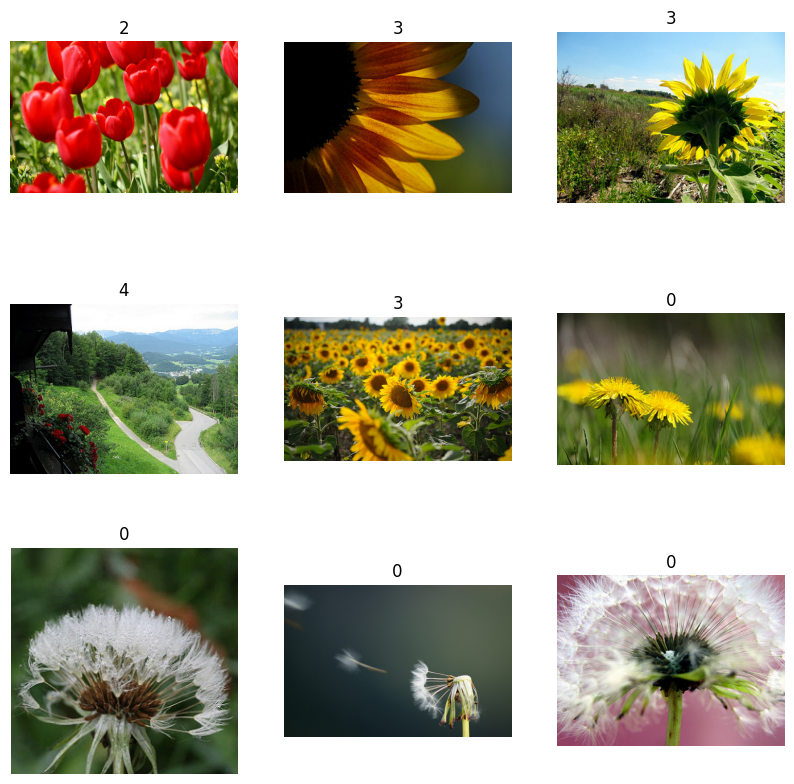

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Define the hyperparameters:

In [4]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

Here are some preprocessing helper functions:

In [5]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    """
    Perform:
        * random flip about the veritcal axis
        * resize the image to a 384 x 384 square
        * randomly crop the image to a 224 x 224 x 3 square
        * rescale the image by 1/255 for pixel intensities
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    """
    Preprocess the test data.

    Note that we must perform the same preprocessing as we did to the training
    set, but we DON'T perform the augmentation steps (random flip and random crop).

    The purpose of the data augmentation steps was to prevent overfitting by 
    generating new data samples, but you wouldn't want to randomly alter your 
    test set. You simply want to know what your average performance would have
    been on real data that you'd see in production.
    """
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

Create a pipeline from those functions:

In [6]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Let's visualize the action of performing our training pipeline on some our input training data:

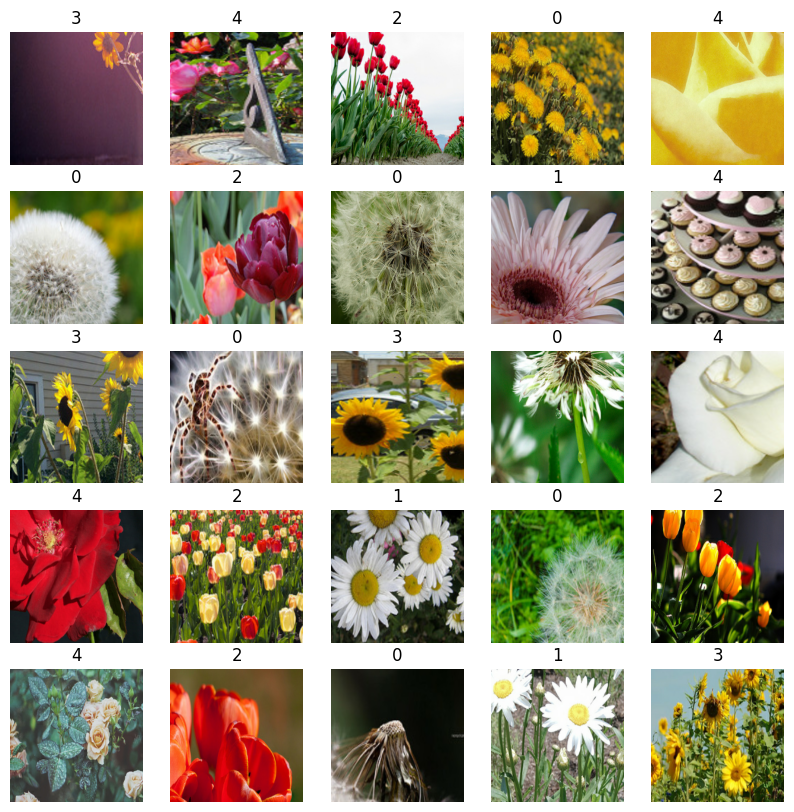

In [7]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

Some of these images were randomly cropped  (or flipped) from their original versions:

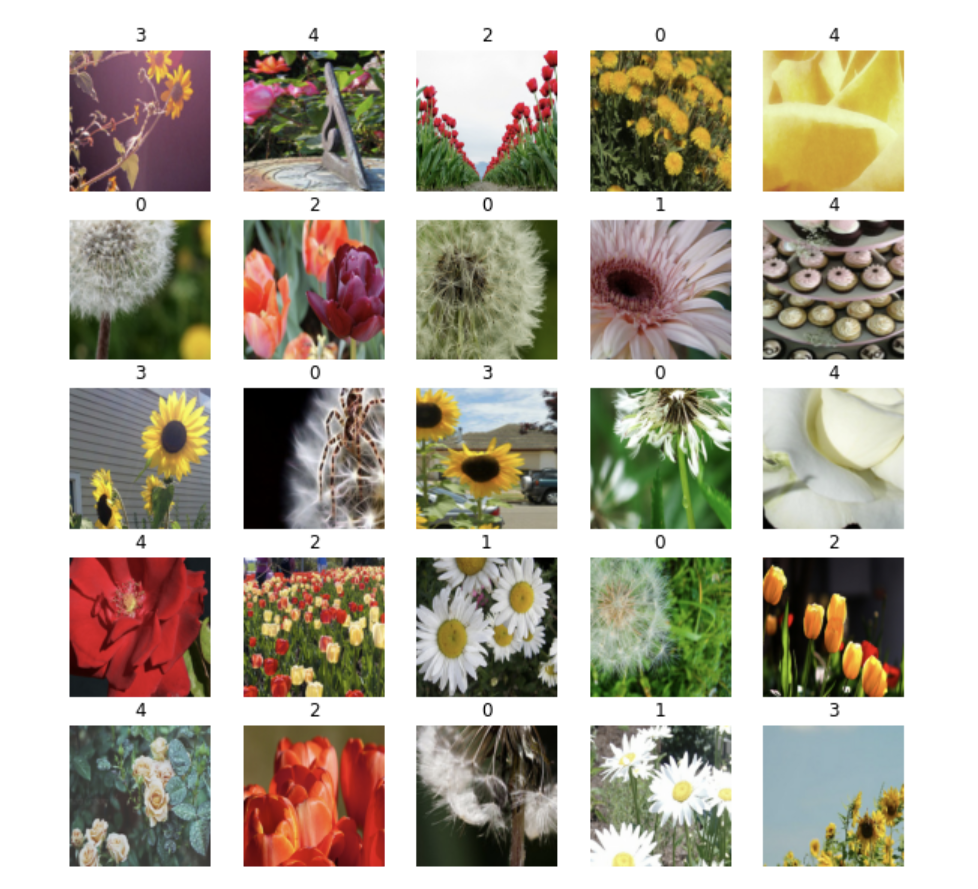

Note image 3 was randomly cropped, and image 1 was randomly flipped.

Here, we download a pre-trained model from TensorFlow hub (look how commoditized this is):

In [8]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## Transfer Learning on BigTransfer

The general prescription for transfer learning is:

1. cut off the final layer of the pre-trained model
2. add a new final layer with number of units equal to the number of classes for our specific task

In [9]:
class MyBiTModel(keras.Model):
    def __init__(self, number_of_classes, pretrained_bit_model, **kwargs):
        super().__init__(**kwargs)

        self.number_of_classes = number_of_classes
        self.head = keras.layers.Dense(
            number_of_classes, 
            kernel_initializer="zeros"
        )
        self.bit_model = pretrained_bit_model

    def call(self, images):
        # first, run the images through out pretrained model
        bit_embedding = self.bit_model(images)
        # then add our final layer on top
        return self.head(bit_embedding)


model = MyBiTModel(
    number_of_classes=NUM_CLASSES, 
    pretrained_bit_model=bit_module
)

Define optimizer and loss, and do setup for training.

The `PiecewiseConstantDecay` learning schedule means to keep the learning rate constant for a number of epochs, then abruptly decrease it at specified intervals. The idea here is that your model will learn more quickly during earlier epochs when the weights are random, and then gradually slow down the learning process as you get to later epochs.

In [10]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [11]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400


2023-07-14 13:48:09.597659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.7461 - accuracy: 0.7922

2023-07-14 13:48:19.255476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 25s 2s/step - loss: 0.7461 - accuracy: 0.7922 - val_loss: 0.1884 - val_accuracy: 0.9545
Epoch 2/400
10/10 [==============================] - 7s 792ms/step - loss: 0.1537 - accuracy: 0.9547 - val_loss: 0.1154 - val_accuracy: 0.9673
Epoch 3/400
10/10 [==============================] - 7s 800ms/step - loss: 0.1854 - accuracy: 0.9359 - val_loss: 0.0940 - val_accuracy: 0.9709
Epoch 4/400
10/10 [==============================] - 7s 776ms/step - loss: 0.1220 - accuracy: 0.9563 - val_loss: 0.0843 - val_accuracy: 0.9673
Epoch 5/400
10/10 [==============================] - 8s 846ms/step - loss: 0.1450 - accuracy: 0.9484 - val_loss: 0.0800 - val_accuracy: 0.9727
Epoch 6/400
10/10 [==============================] - 7s 782ms/step - loss: 0.1137 - accuracy: 0.9516 - val_loss: 0.0773 - val_accuracy: 0.9764
Epoch 7/400
10/10 [==============================] - 7s 752ms/step - loss: 0.1293 - accuracy: 0.9547 - val_loss: 0.0826 - val_accuracy: 0.9727
Epoch 8/400
1

Note that we stopped really early (after only 12 epochs) because we set our `patience` to 2 on the early stopping callback.

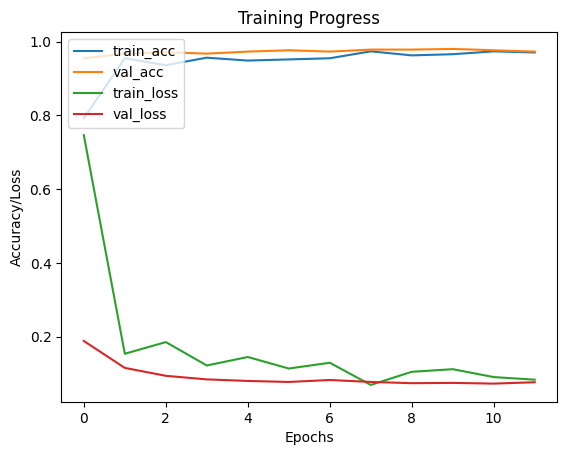

In [12]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

Finally, we can evaluate our model on our validation set:

In [13]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 5s 492ms/step - loss: 0.0748 - accuracy: 0.9800
Accuracy: 98.00%
